In [2]:
#Importing packages
import pandas as pd                 
import numpy as np                   
from matplotlib import pyplot as plt
import pickle

import sklearn
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

%config InlineBackend.figure_formats = ['svg']

df = pd.read_csv('fetal_health.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [2]:
#Data processing
df.dropna(inplace = True)
output = df['fetal_health']
features = df.drop(columns=['fetal_health'], inplace=False)

In [3]:
#Splitting dataset, fitting models except soft voting classifier
train_X, test_X, train_y, test_y = train_test_split(features, output, test_size = 0.2, random_state=1)
dt_clf =  DecisionTreeClassifier(random_state = 1)
rf_clf = RandomForestClassifier(random_state = 1)
ada_clf = AdaBoostClassifier(random_state = 1)

dt_clf.fit(train_X, train_y)
rf_clf.fit(train_X, train_y)
ada_clf.fit(train_X, train_y)

c:\Users\Tillman\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(random_state=1)

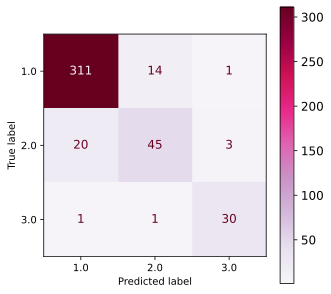

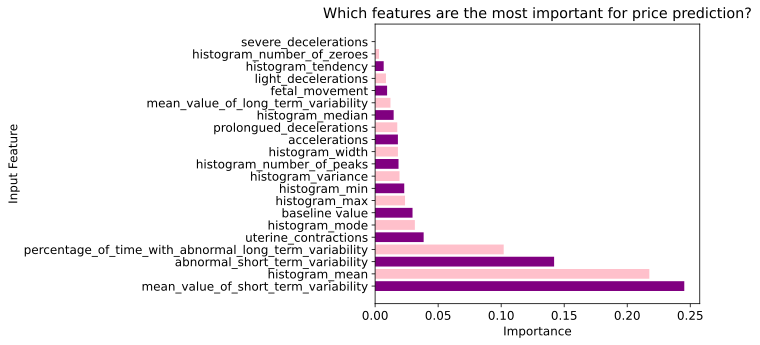

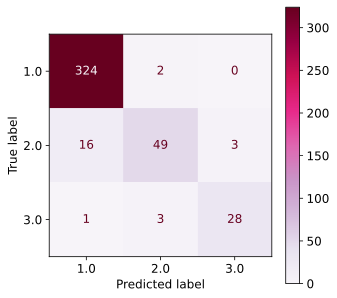

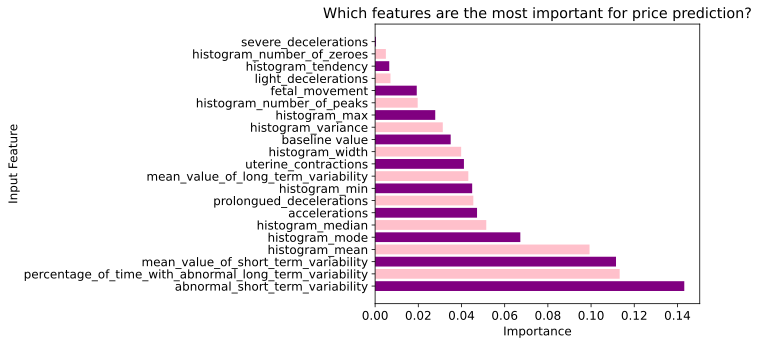

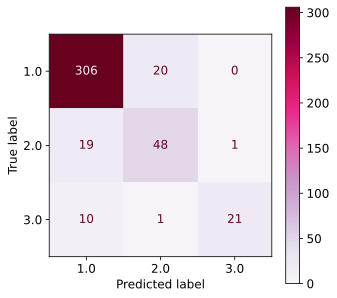

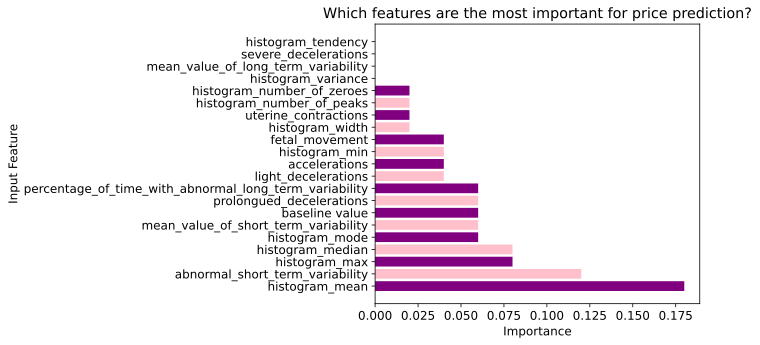

In [4]:
def save_figures_clf(clf, file_suffix, vote = False, importances = None):
    # Predictions on test set
    y_pred = clf.predict(test_X)

    # Now generate confusion matrix
    cm = confusion_matrix(test_y, y_pred, labels = clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)

    # Specify figure size
    fig, ax = plt.subplots(figsize = (5, 5))
    plt.rcParams.update({'font.size': 12})

    # Display Confusion Matrix
    disp.plot(cmap = 'PuRd', ax = ax)
    plt.savefig(f"confusion_mat_{file_suffix}.svg");

    report = classification_report(test_y, y_pred, output_dict = True)
    report_df = pd.DataFrame(report)
    report_df.to_csv(f'class_report_{file_suffix}.csv');

    if not vote:
    # Storing importance values from the trained model
        importance = clf.feature_importances_
    else: 
        importance = importances
    # Storing feature importance as a dataframe
    feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
                columns = ['Feature', 'Importance'])

    feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)
    #feature_imp: percentage reduction in gini impurity by each input feature

    # Bar plot
    plt.figure(figsize=(10, 5))
    plt.barh(feature_imp['Feature'], feature_imp['Importance'], color = ['purple', 'pink'])

    plt.xlabel("Importance")
    plt.ylabel("Input Feature")
    plt.title('Which features are the most important for price prediction?') 
    plt.tight_layout()
    plt.savefig(f"feature_imp_{file_suffix}.svg");

save_figures_clf(dt_clf, file_suffix="dt")
save_figures_clf(rf_clf, file_suffix="rf")
save_figures_clf(ada_clf, file_suffix="ada")

#### ADA F1 Macro: 0.8014591996283086
#### DT F1 Macro: 0.852501554296767
#### RF F1 Macro: 0.8878939400973466

In [5]:
#Implementing voting classifier model
ada_macro, dt_macro, rf_macro = 0.8878939400973466, 0.852501554296767, 0.8878939400973466

macro_sum = ada_macro + dt_macro + rf_macro
ada_weight = ada_macro / macro_sum
dt_weight = dt_macro / macro_sum
rf_weight = rf_macro / macro_sum

vot_clf = VotingClassifier(estimators=[('ada', ada_clf),
                                       ('dt', dt_clf),
                                       ('rf', rf_clf)],
                           weights=[ada_weight, dt_weight, rf_weight],
                           voting='soft')

vot_clf.fit(train_X, train_y)

c:\Users\Tillman\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


VotingClassifier(estimators=[('ada', AdaBoostClassifier(random_state=1)),
                             ('dt', DecisionTreeClassifier(random_state=1)),
                             ('rf', RandomForestClassifier(random_state=1))],
                 voting='soft',
                 weights=[0.33782197974293593, 0.32435604051412814,
                          0.33782197974293593])

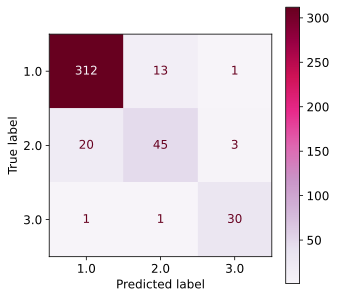

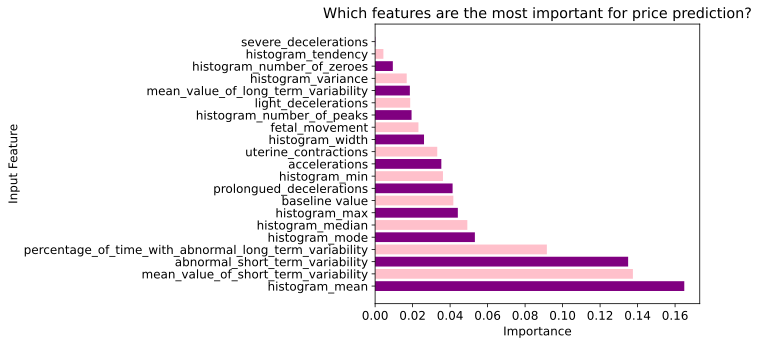

In [6]:
#Getting voting classifier feature importances, confusion matrix, and classification report
dt_importance = dt_clf.feature_importances_ * dt_weight
rf_importance = rf_clf.feature_importances_ * rf_weight
ada_importance = ada_clf.feature_importances_ * ada_weight

vot_importance = dt_importance + rf_importance + ada_importance
save_figures_clf(vot_clf, file_suffix="vot", vote=True, importances=vot_importance)

In [7]:
dt_pickle = open('decision_tree_pickle.pkl', 'wb')
pickle.dump(dt_clf, dt_pickle)
dt_pickle.close()

rf_pickle = open('random_forest_pickle.pkl', 'wb')
pickle.dump(rf_clf, rf_pickle)
rf_pickle.close()

ada_pickle = open('adaBoost_pickle.pkl', 'wb')
pickle.dump(ada_clf, ada_pickle)
ada_pickle.close()

vote_pickle = open('softVoting_pickle.pkl', 'wb')
pickle.dump(vot_clf, vote_pickle)
vote_pickle.close()